In [101]:
import pandas as pd
import numpy as np
import sys
import os
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simpledbf import Dbf5
import openmatrix as omx
import re
import geopandas as gpd
from shapely.geometry import Point, LineString

TRANSIT_INPUT = r'E:\Met_Council\metc-asim-model\Input_2022\transit\PT_2022.lin'
NODES = gpd.read_file(r'E:\Met_Council\metc-asim-model\Base_2022\transit\node.dbf')
MODEL_OUTPUT = r'E:\Met_Council\metc-asim-model\Base_2022'
OBS_SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\OBS_survey'
ITERATION = 3
ASIM_EXPANSION_FACTOR = 0.20767

# obs_survey = pd.read_excel(os.path.join(OBS_SURVEY_PATH, 'Met Council OD 2022.xlsx'), "data")
# obs_survey.to_pickle(os.path.join(OBS_SURVEY_PATH, 'obs_survey.pkl'))
obs_survey = pd.read_pickle(os.path.join(OBS_SURVEY_PATH, 'obs_survey.pkl'))

In [102]:
def read_card(input_file, group_id, key_id, nxy_table):
    with open(input_file, 'r') as fr:
        lines = fr.readlines()
    lines = [line.rstrip('\n') for line in lines]
    lines = [line for line in lines if line[0] != ';']
    lines = ''.join(lines)
    lines = lines.split(group_id)
    lines = [dict(re.findall(r'(\S+)\s*\=\s*(.*?)\s*(?=\S+\s*\=|$)', line)) for line in lines]
    out_lines = []
    for line in lines:
        if 'NAME' in line.keys():
            x = {}
            x['route_id'] = line['NAME']
            for k, v in line.items():
                if not k in ['NAME', 'N']:
                    x[k] = v.replace('"',"").replace(',','')
            coords = nxy_table.loc[[abs(int(n)) for n in line['N'].replace('\n','').replace(' ', '').split(',')]]
            geom = LineString([tuple(x) for x in coords.to_numpy()])
            x['geometry'] = geom
            out_lines.append(x)             
    return out_lines

In [103]:
model_transit_lines = gpd.GeoDataFrame(read_card(r'E:\Met_Council\metc-asim-model\Input_2022\transit\PT_2022.lin', 'LINE', 'NAME', NODES[['N', 'X', 'Y']].set_index('N')))

#.to_file('trn_routes.shp')

# ActivitySim Output

This is for diagnostics

In [104]:
# Read Asim Outputs
# tours = pd.read_csv(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', 'final_tours.csv'))
# trips = pd.read_csv(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', 'final_trips.csv'))


In [105]:
trn_mode_period = []
for period in ['EA', 'AM', 'MD', 'PM', 'NT']:
    try:
        #omx_file = omx.open_file(os.path.join(MODEL_OUTPUT, 'ActivitySim', 'output', f'transit_{period}.omx'), 'r')
        omx_file = omx.open_file(os.path.join(MODEL_OUTPUT, 'transit', f'XIT_TRIP_{ITERATION}_{period}_CLEAN.omx'), 'r')
        
        for table in omx_file.list_matrices():
            print(f"Period: {period}, table: {table}, sum: {np.array(omx_file[table]).sum()}")
            trn_mode_period.append([period, table, np.array(omx_file[table]).sum()])

    finally:
        omx_file.close()
        print("File closed")

trn_mode_period = pd.DataFrame(trn_mode_period, columns = ['period', 'table', 'trips'])


Period: EA, table: DriveToTransit, sum: 481.0
Period: EA, table: TrnDriveEgress, sum: 1196.0
Period: EA, table: WalkToTransit, sum: 4219.199999999999
File closed
Period: AM, table: DriveToTransit, sum: 5750.0
Period: AM, table: TrnDriveEgress, sum: 405.0
Period: AM, table: WalkToTransit, sum: 23911.240000000045
File closed
Period: MD, table: DriveToTransit, sum: 6192.499999999999
Period: MD, table: TrnDriveEgress, sum: 993.0
Period: MD, table: WalkToTransit, sum: 21790.0
File closed
Period: PM, table: DriveToTransit, sum: 2955.3800000000006
Period: PM, table: TrnDriveEgress, sum: 5634.0
Period: PM, table: WalkToTransit, sum: 28348.0
File closed
Period: NT, table: DriveToTransit, sum: 560.0
Period: NT, table: TrnDriveEgress, sum: 3444.0
Period: NT, table: WalkToTransit, sum: 14291.0
File closed


In [106]:
model_pertrip_totals = pd.concat([
    trn_mode_period.pivot(index = 'period', columns = 'table', values = 'trips'),
    trn_mode_period.groupby('table').agg(trips = ('trips', 'sum')).assign(period = 'Total').reset_index().pivot(index = 'period', columns = 'table', values = 'trips')
])

model_linked_trips = model_pertrip_totals[model_pertrip_totals.index == 'Total'].sum(1)

model_pertrip_totals.style.format('{:,.0f}')

table,DriveToTransit,TrnDriveEgress,WalkToTransit
period,,,
AM,"5,750",405,"23,911"
EA,481,"1,196","4,219"
MD,"6,192",993,"21,790"
NT,560,"3,444","14,291"
PM,"2,955","5,634","28,348"
Total,"15,939","11,672","92,559"


In [107]:
trnload = {}

for per in ['EA', 'AM', 'MD', 'PM', 'NT']:
    for am in ['WK', 'DR', 'DRE']:
        trnload[f'{per}_{am}'] = Dbf5(os.path.join(MODEL_OUTPUT, 'transit', f'XIT_{am}_LD_{ITERATION}_{per}.dbf')).to_dataframe()


# Read Survey Data

In [108]:
obs_survey['ROUTE_NAME'] = obs_survey['ROUTE_DIRECTIONCode'].apply(lambda x: x[x.find("_") + 3: x.rfind("_")])
obs_ridership = obs_survey.groupby('ROUTE_NAME').agg(obs_ridership = ('Final_unlinked_weight_fctr', 'sum')) #, wtd_linked_trips = ('Final_Linked_weight_fctr', 'sum'))

In [109]:
obs_transfer = obs_survey.Final_unlinked_weight_fctr.sum() / obs_survey.Final_Linked_weight_fctr.sum()
print(f"Survey trips: {obs_survey.Final_Linked_weight_fctr.sum():,.0f}; ridership: {obs_survey.Final_unlinked_weight_fctr.sum():,.0f}; tranfer rate is {obs_transfer: ,.4f}")

Survey trips: 124,008; ridership: 147,929; tranfer rate is  1.1929


# Read Model Output

In [110]:
trn_summary = pd.concat(trnload)
# trn_summary.groupby('MODE').agg(distance = ('DIST', 'sum'), time = ('TIME', 'sum'), boards = ('ONA', 'sum')).assign(speed = lambda x: x['distance'] / (x['time'] / 60.0))

In [111]:
trn_summary['ROUTE_NAME'] = ''
trn_summary.loc[trn_summary['NAME'].str.find("_") > 0, 'ROUTE_NAME'] = trn_summary['NAME'].apply(lambda x: x[:x.find("_")])

trn_summary.groupby(['NAME', 'MODE', 'OPERATOR']).agg(boards = ('ONA', 'sum')).to_excel("trn_line_summ.xlsx")
trn_valid_summary = obs_ridership.join(trn_summary[~trn_summary['NAME'].isin(['*1', '*2', '*3', '*4'])].groupby(['ROUTE_NAME', 'MODE']).agg(DIST = ('DIST', 'sum'), TIME = ('TIME', 'sum'), model_ridership = ('ONA', 'sum')), how = 'left')

trn_valid_summary.to_excel('transit_loadings.xlsx')

In [112]:
pd.DataFrame(trn_valid_summary[['model_ridership', 'obs_ridership']].sum()).style.format('{:,.0f}')

,0
model_ridership,"150,339"
obs_ridership,"147,691"


In [113]:
mod_transfer = trn_valid_summary['model_ridership'].sum() / model_linked_trips['Total']
print(f"Observed Transfer Rate: {obs_transfer:0.2f}; Model Transfer Rate: {mod_transfer: 0.2f}")

Observed Transfer Rate: 1.19; Model Transfer Rate:  1.25


In [114]:
vmt_diff = trn_valid_summary['model_ridership'].sum() - trn_valid_summary['obs_ridership'].sum()
pct_diff = vmt_diff / trn_valid_summary['obs_ridership'].sum()
print(f"Difference: {vmt_diff:,.0f} ({pct_diff:.2%})")

Difference: 2,648 (1.79%)


In [115]:
trn_valid_summary.reset_index(inplace = True)
trn_valid_summary['transit_mode'] = 'Bus'
trn_valid_summary.loc[trn_valid_summary['MODE'] == 8, 'transit_mode'] = 'LRT'
trn_valid_summary.loc[trn_valid_summary['MODE'] == 9, 'transit_mode'] = 'CRT'
mode_summary = pd.DataFrame(trn_valid_summary.groupby('transit_mode').agg(model = ('model_ridership', 'sum'), obs = ('obs_ridership', 'sum')))
mode_summary.loc['total'] = mode_summary.sum(0)
mode_summary['diff'] = mode_summary['model'] - mode_summary['obs']
mode_summary['pdiff'] = mode_summary['diff'] / mode_summary['obs']

mode_summary.style.format({'model': '{:,.0f}', 'obs': '{:,.0f}', 'diff': '{:,.0f}', 'pdiff':'{:,.1%}'})

,model,obs,diff,pdiff
transit_mode,,,,
Bus,"124,477","121,190","3,287",2.7%
CRT,258,361,-103,-28.5%
LRT,"25,603","26,139",-536,-2.1%
total,"150,339","147,691","2,648",1.8%


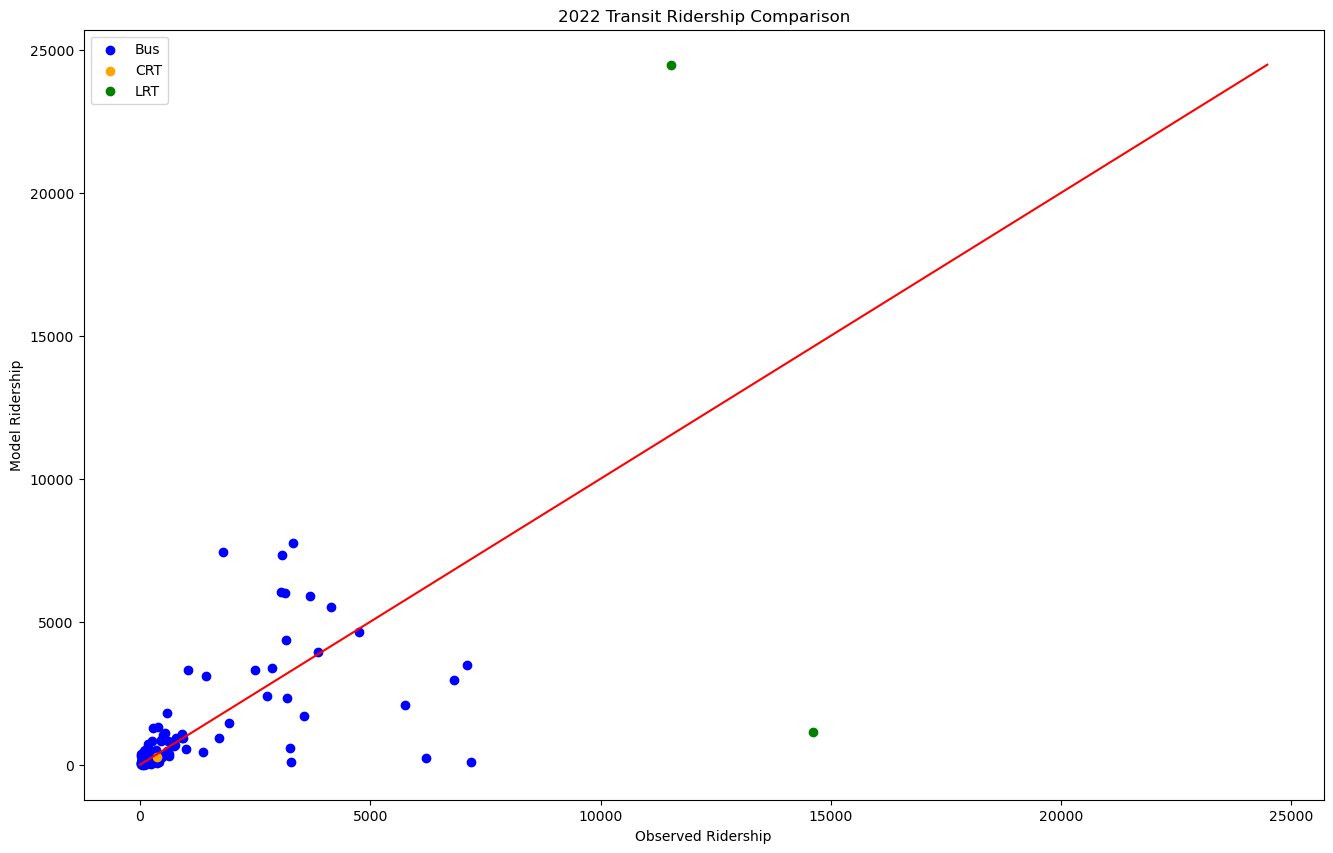

In [116]:
fig = plt.figure(figsize=(16,10))
color_guide = {'Bus': 'blue', 'LRT': 'green', 'CRT': 'orange'}
ax = fig.add_subplot()
sc = ax.plot([0, np.max(trn_valid_summary[['model_ridership', 'obs_ridership']].max())], [0, np.max(trn_valid_summary[['model_ridership', 'obs_ridership']].max())], c = 'red')
for m in trn_valid_summary['transit_mode'].unique():
    ax.scatter(trn_valid_summary[trn_valid_summary['transit_mode'] == m]['obs_ridership'], 
        trn_valid_summary[trn_valid_summary['transit_mode'] == m]['model_ridership'], marker='o', 
        c = color_guide[m], label = m)
plt.title("2022 Transit Ridership Comparison")

plt.legend(loc='upper left')
ax.set_xlabel('Observed Ridership')
ax.set_ylabel('Model Ridership')
plt.show()

In [117]:
model_transit_lines['ROUTE_NAME'] = model_transit_lines['route_id'].apply(lambda x: x[1:x.find("_")])
model_transit_lines['o_rider'] = np.array(trn_valid_summary.reset_index()[['ROUTE_NAME', 'obs_ridership']].set_index('ROUTE_NAME').reindex(model_transit_lines['ROUTE_NAME']).fillna(0))
model_transit_lines['m_rider'] = np.array(trn_valid_summary.reset_index()[['ROUTE_NAME', 'model_ridership']].set_index('ROUTE_NAME').reindex(model_transit_lines['ROUTE_NAME']).fillna(0))

# diff, abs_diff, pct_diff
model_transit_lines['diff'] = model_transit_lines['m_rider'] - model_transit_lines['o_rider']
model_transit_lines['a_diff'] = abs(model_transit_lines['diff'])
model_transit_lines['p_diff'] = model_transit_lines.apply(lambda x: x['diff'] / x['o_rider'] if x['o_rider'] > 0 else 0, axis = 1)

model_transit_lines.to_file('trn_routes.shp')